In [1]:
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys

In [2]:
import librosa
import librosa.display
import IPython.display as ipd

In [3]:
random.seed(42)
np.random.seed(42)

n_mels = 64
frames = 5
n_fft = 2048
hop_length = 512
power = 2.0

blue, red = (1.0, 0.0, 0.0), (0.0, 0.0, 1.0)

DATA = os.path.join('data')
PROCESSED_DATA = os.path.join('data', 'processed')
MODELS = os.path.join('models')

In [4]:
def load_sound_file(wav_name, mono=False, channel=0):
    multi_channel_data, sampling_rate = librosa.load(wav_name, sr=None, mono=mono)
    signal = np.array(multi_channel_data)[channel, :]
    
    return signal, sampling_rate

The signals have a (160000,) shape. At 16000 Hz, these are 10s signals


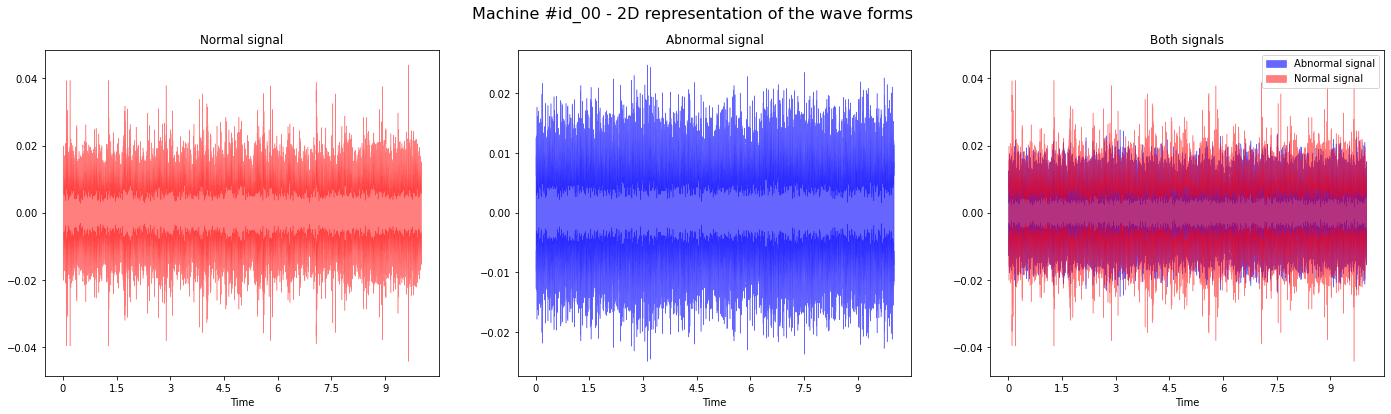

In [5]:
normal_signal_file = os.path.join(DATA, 'pump', 'id_00', 'normal', '00000100.wav')
abnormal_signal_file = os.path.join(DATA, 'pump', 'id_00', 'abnormal', '00000100.wav')
normal_signal, sr = load_sound_file(normal_signal_file)
abnormal_signal, sr = load_sound_file(abnormal_signal_file)
print(f'The signals have a {normal_signal.shape} shape. At {sr} Hz, these are {normal_signal.shape[0]/sr:.0f}s signals')

fig = plt.figure(figsize=(24, 6))
plt.subplot(1,3,1)
librosa.display.waveshow(normal_signal, sr=sr, alpha=0.5, color=blue, linewidth=0.5, label='Machine #id_00 - Normal signal')
plt.title('Normal signal')

plt.subplot(1,3,2)
librosa.display.waveshow(abnormal_signal, sr=sr, alpha=0.6, color=red, linewidth=0.5, label='Machine #id_00 - Abnormal signal')
plt.title('Abnormal signal')

plt.subplot(1,3,3)
librosa.display.waveshow(abnormal_signal, sr=sr, alpha=0.6, color=red, linewidth=0.5, label='Abnormal signal')
librosa.display.waveshow(normal_signal, sr=sr, alpha=0.5, color=blue, linewidth=0.5, label='Normal signal')
plt.title('Both signals')

fig.suptitle('Machine #id_00 - 2D representation of the wave forms', fontsize=16)
plt.legend();

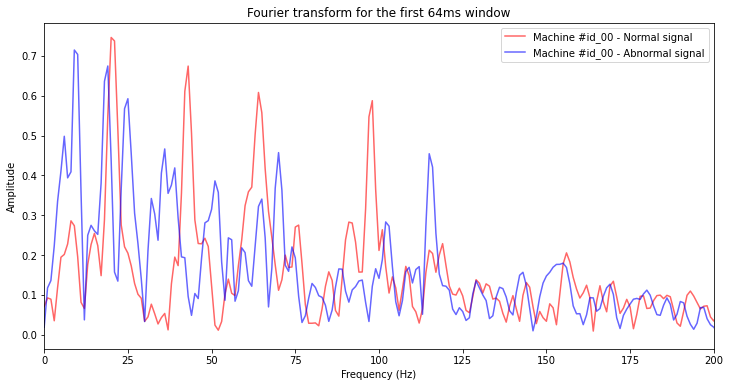

In [6]:
D_normal = np.abs(librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))
D_abnormal = np.abs(librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))

fig = plt.figure(figsize=(12, 6))
plt.plot(D_normal, color=blue, alpha=0.6, label='Machine #id_00 - Normal signal');
plt.plot(D_abnormal, color=red, alpha=0.6, label='Machine #id_00 - Abnormal signal');
plt.title('Fourier transform for the first 64ms window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(0, 200);

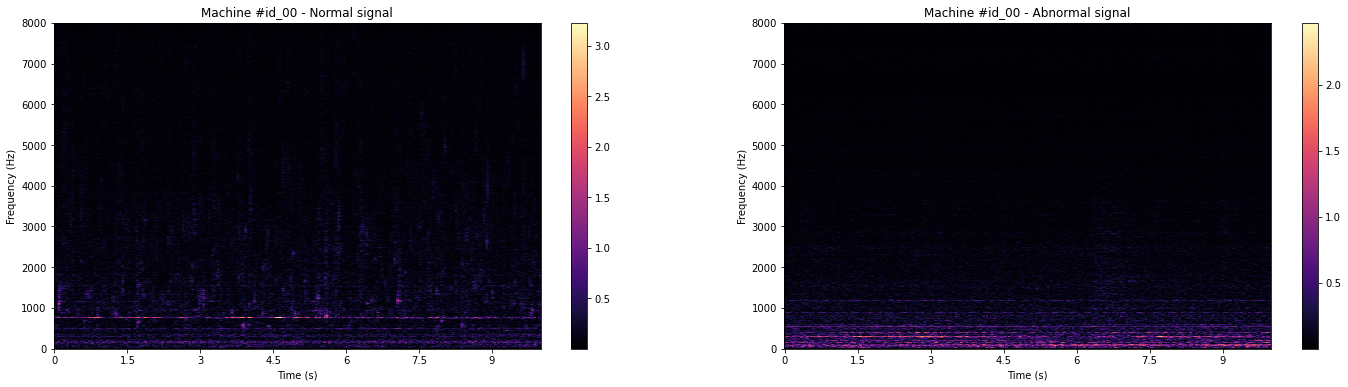

In [7]:
D_normal = np.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
D_abnormal = np.abs(librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length))

fig = plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(D_normal, sr=sr, x_axis='time', y_axis='linear');
plt.title('Machine #id_00 - Normal signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar();

plt.subplot(1, 2, 2)
librosa.display.specshow(D_abnormal, sr=sr, x_axis='time', y_axis='linear');
plt.title('Machine #id_00 - Abnormal signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar();

In [8]:
def convert_to_dB(file, n_fft=1024, hop_length=512):
    signal, sampling_rate = load_sound_file(file)
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    dB = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    return dB

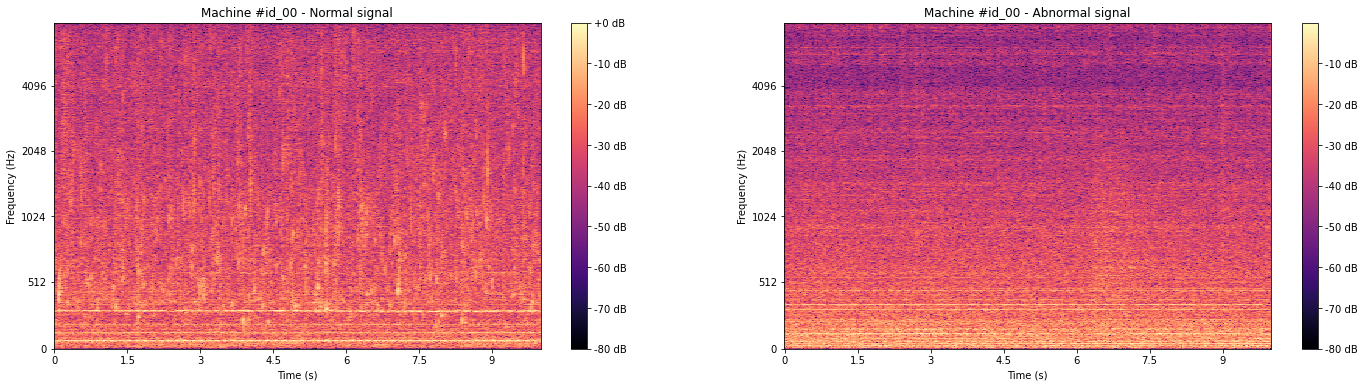

In [9]:
dB_normal = convert_to_dB(normal_signal_file, n_fft=n_fft, hop_length=hop_length)
dB_abnormal = convert_to_dB(abnormal_signal_file, n_fft=n_fft, hop_length=hop_length)

fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(dB_normal, sr=sr, x_axis='time', y_axis='mel')
plt.title('Machine #id_00 - Normal signal')
plt.colorbar(format="%+2.f dB")
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(1, 2, 2)
librosa.display.specshow(dB_abnormal, sr=sr, x_axis='time', y_axis='mel')
plt.title('Machine #id_00 - Abnormal signal')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format="%+2.f dB")
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.show()

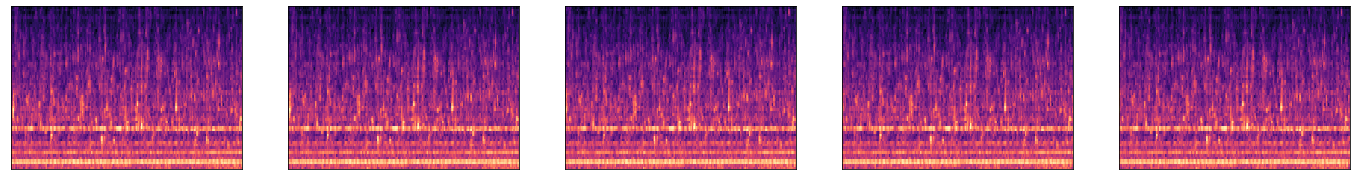

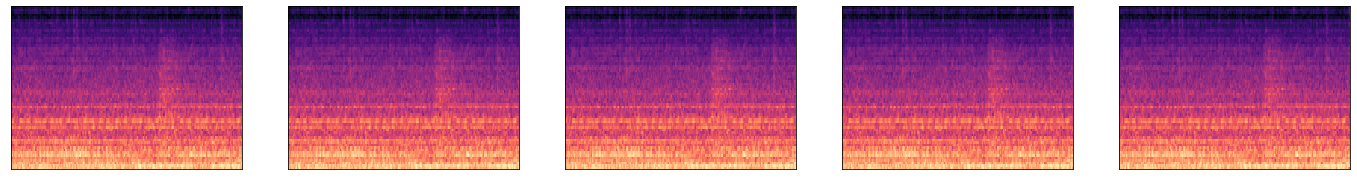

In [10]:
normal_mel = librosa.feature.melspectrogram(y=normal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
normal_S_DB = librosa.power_to_db(normal_mel, ref=np.max)
abnormal_mel = librosa.feature.melspectrogram(y=abnormal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
abnormal_S_DB = librosa.power_to_db(abnormal_mel, ref=np.max)

frames = 5
stride = 1
dims = frames * n_mels

features_vector_size = normal_S_DB.shape[1] - frames + 1
features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    features[:, n_mels * t: n_mels * (t + 1)] = normal_S_DB[:, t:t + features_vector_size].T
fig = plt.figure(figsize=(24, 3))
for t in range(frames):
    plt.subplot(1, frames, t + 1)
    librosa.display.specshow(features[:, n_mels * t: n_mels * (t + 1)].T, sr=sr, hop_length=hop_length);
    
features_vector_size = abnormal_S_DB.shape[1] - frames + 1
features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    features[:, n_mels * t: n_mels * (t + 1)] = abnormal_S_DB[:, t:t + features_vector_size].T
fig = plt.figure(figsize=(24, 3))
for t in range(frames):
    plt.subplot(1, frames, t + 1)
    librosa.display.specshow(features[:, n_mels * t: n_mels * (t + 1)].T, sr=sr, hop_length=hop_length);

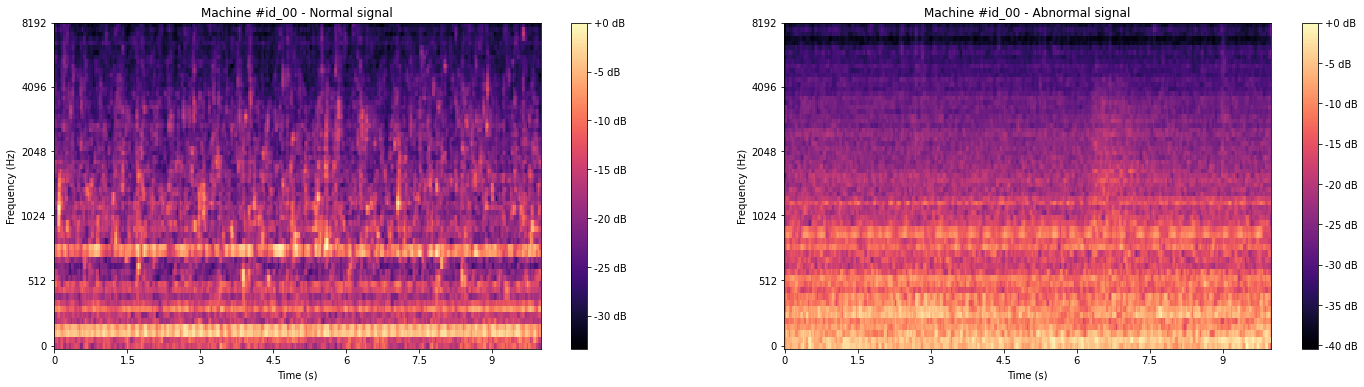

In [11]:
fig = plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(normal_S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.title('Machine #id_00 - Normal signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB');

plt.subplot(1, 2, 2)
librosa.display.specshow(abnormal_S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.title('Machine #id_00 - Abnormal signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB');

In [12]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from shapely.geometry import LineString
import pandas as pd
import seaborn as sns

In [13]:
def make_autoencoder(input_dims):
    inputLayer = Input(shape=(input_dims,))
    h = Dense(128, activation="relu")(inputLayer)
    h = Dense(128, activation="relu")(h)
    h = Dense(16, activation="relu")(h)
    h = Dense(128, activation="relu")(h)
    h = Dense(128, activation="relu")(h)
    h = Dense(input_dims, activation=None)(h)

    return Model(inputs=inputLayer, outputs=h)

In [14]:
def extract_signal_features(signal, sr, n_mels=64, frames=5, n_fft=1024, hop_length=512):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    
    dims = frames * n_mels
    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)
    
    features = np.zeros((features_vector_size, dims), np.float32)
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t:t + features_vector_size].T
        
    return features

In [15]:
def generate_dataset(files_list, n_mels=64, frames=5, n_fft=1024, hop_length=512):
    dims = n_mels * frames
    
    for index in tqdm(range(len(files_list)), desc='Extracting features'):
        signal, sr = load_sound_file(files_list[index])
        
        features = extract_signal_features(
            signal, 
            sr, 
            n_mels=n_mels, 
            frames=frames, 
            n_fft=n_fft, 
            hop_length=hop_length
        )
                
        if index == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)
            
        dataset[features.shape[0] * index : features.shape[0] * (index + 1), :] = features

    return dataset

In [16]:
def build_files_list(root_dir, abnormal_dir='abnormal', normal_dir='normal'):
    normal_files = []
    abnormal_files = []
    
    for root, dirs, files in os.walk(top = os.path.join(root_dir)):
        for name in files:
            current_dir_type = root.split('/')[-1]
            if abnormal_dir in current_dir_type:
                abnormal_files.append(os.path.join(root, name))
            if normal_dir in current_dir_type:
                normal_files.append(os.path.join(root, name))
                
    return normal_files, abnormal_files

In [17]:
normal_files, abnormal_files = build_files_list(root_dir=os.path.join(DATA, 'pump'))

X = np.concatenate((normal_files, abnormal_files), axis=0)
y = np.concatenate((np.zeros(len(normal_files)), np.ones(len(abnormal_files))), axis=0)

train_files, test_files, train_labels, test_labels = train_test_split(
    X, y,
    train_size=0.8,
    random_state=42,
    shuffle=True,
    stratify=y
)

dataset = dict({
    'train_files': train_files,
    'test_files': test_files,
    'train_labels': train_labels,
    'test_labels': test_labels
})

for key, values in dataset.items():
    fname = os.path.join(PROCESSED_DATA, key + '.txt')
    with open(fname, 'w') as f:
        for item in values:
            f.write(str(item))
            f.write('\n')

train_files = [f for f in train_files if f not in abnormal_files]
train_labels = np.zeros(len(train_files))

In [18]:
hyperparameters={
    'epochs': 25,
    'batch_size': 512,
    'lr': 1e-3,
    'n_mels': n_mels,
    'frame': frames,
}

In [19]:
train_data = generate_dataset(train_files, n_mels=n_mels, frames=frames, n_fft=n_fft, hop_length=hop_length)

Extracting features: 100%|██████████| 3003/3003 [00:44<00:00, 67.38it/s]


In [20]:
model_dir = os.path.join('models', 'autoencoder')
model = make_autoencoder(train_data[0].shape[0])
print(model.summary())

model.compile(
    loss='mse',
    optimizer='adamax',
    metrics=['accuracy']
)

history = model.fit(
    train_data, 
    train_data,
    batch_size=hyperparameters['batch_size'],
    validation_split=0.1,
    epochs=hyperparameters['epochs'],
    shuffle=True,
    # verbose=2,
)

os.makedirs(os.path.join(model_dir, 'model/1'), exist_ok=True)
model.save(os.path.join(model_dir, 'model/1'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense (Dense)               (None, 128)               41088     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 128)               2176      
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 320)               41280 

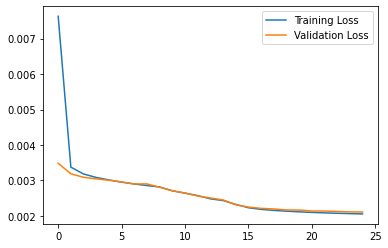

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [22]:
y_true = test_labels
reconstruction_errors = []

for index, eval_filename in tqdm(enumerate(test_files), total=len(test_files)):
    signal, sr = load_sound_file(eval_filename)
    eval_features = extract_signal_features(
        signal,
        sr,
        n_mels=n_mels,
        frames=frames,
        n_fft=n_fft,
        hop_length=hop_length
    )
    prediction = model.predict(eval_features)
    
    mse = np.mean(np.mean(np.square(eval_features - prediction), axis=1))
    reconstruction_errors.append(mse)

100%|██████████| 933/933 [00:51<00:00, 18.10it/s]


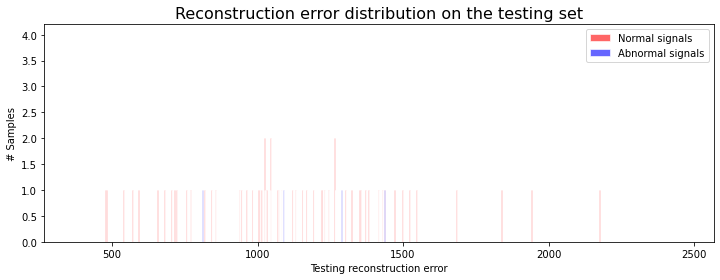

In [23]:
data = np.column_stack((range(len(reconstruction_errors)), reconstruction_errors))
bin_width = 0.25
bins = np.arange(min(reconstruction_errors), max(reconstruction_errors) + bin_width, bin_width)

fig = plt.figure(figsize=(12,4))
plt.hist(data[y_true==0][:,1], bins=bins, color=blue, alpha=0.6, label='Normal signals', edgecolor='#FFFFFF')
plt.hist(data[y_true==1][:,1], bins=bins, color=red, alpha=0.6, label='Abnormal signals', edgecolor='#FFFFFF')
plt.xlabel("Testing reconstruction error")
plt.ylabel("# Samples")
plt.title('Reconstruction error distribution on the testing set', fontsize=16)
plt.legend()
plt.show()

In [48]:
threshold_min = 800
threshold_max = 1800
threshold_step = 5

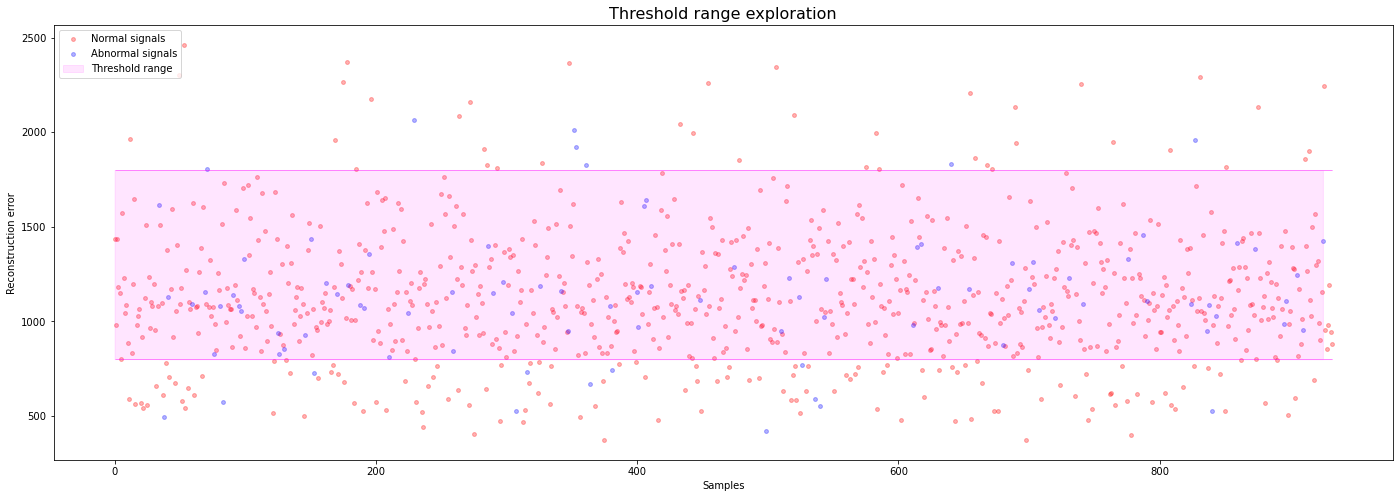

In [49]:
normal_x, normal_y = data[y_true==0][:,0], data[y_true==0][:,1]
abnormal_x, abnormal_y = data[y_true==1][:,0], data[y_true==1][:,1]
x = np.concatenate((normal_x, abnormal_x))

fig, ax = plt.subplots(figsize=(24,8))
plt.scatter(normal_x, normal_y, s=15, color=blue, alpha=0.3, label='Normal signals')
plt.scatter(abnormal_x, abnormal_y, s=15, color=red, alpha=0.3,   label='Abnormal signals')
plt.fill_between(x, threshold_min, threshold_max, alpha=0.1, color='magenta', label='Threshold range')
plt.hlines([threshold_min, threshold_max], x.min(), x.max(), linewidth=0.5, alpha=0.8, color='magenta')
plt.legend(loc='upper left')
plt.title('Threshold range exploration', fontsize=16)
plt.xlabel('Samples')
plt.ylabel('Reconstruction error')
plt.show()

In [50]:
def generate_error_types(df, ground_truth_col='Ground Truth', prediction_col='Prediction', normal_label=0.0, anomaly_label=1.0):
    df['TP'] = 0
    df['TN'] = 0
    df['FP'] = 0
    df['FN'] = 0
    df.loc[(df[ground_truth_col] == df[prediction_col]) & (df[ground_truth_col] == normal_label), 'TP'] = 1
    df.loc[(df[ground_truth_col] == df[prediction_col]) & (df[ground_truth_col] == anomaly_label), 'TN'] = 1
    df.loc[(df[ground_truth_col] != df[prediction_col]) & (df[ground_truth_col] == normal_label), 'FP'] = 1
    df.loc[(df[ground_truth_col] != df[prediction_col]) & (df[ground_truth_col] == anomaly_label), 'FN'] = 1
    
    return df

In [51]:
def plot_curves(FP, FN, nb_samples, threshold_min, threshold_max, threshold_step):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    min_FN = np.argmin(FN)
    min_FP = np.where(FP == np.min(FP))[0][-1]
    plot_top = max(FP + FN) + 1

    major_ticks = np.arange(threshold_min, threshold_max, 1.0 * threshold_step)
    minor_ticks = np.arange(threshold_min, threshold_max, 0.2 * threshold_step)
    ax.set_xticks(major_ticks);
    ax.set_xticks(minor_ticks, minor=True);
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=1.0, linewidth=1.0)
    
    x = np.arange(threshold_min, threshold_max + threshold_step, threshold_step)
    
    first_line = LineString(np.column_stack((x, FP)))
    second_line = LineString(np.column_stack((x, FN)))
    intersection = first_line.intersection(second_line)
                             
    if intersection.geom_type == 'MultiPoint':
        plt.plot(*LineString(intersection).xy, 'mo')
    elif intersection.geom_type == 'Point':
        plt.plot(*intersection.xy, 'mo')

    plt.plot(x, FP, label='False positive', color=red)
    plt.plot(x, FN, label='False negative', color=blue)

    plt.xlabel('Reconstruction error threshold (%)', fontsize=16)
    plt.ylabel('# Samples', fontsize=16)
    plt.legend()
    
    return intersection.xy[0]

In [52]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, 
                         index=class_names, 
                         columns=class_names)
    
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    
    return fig

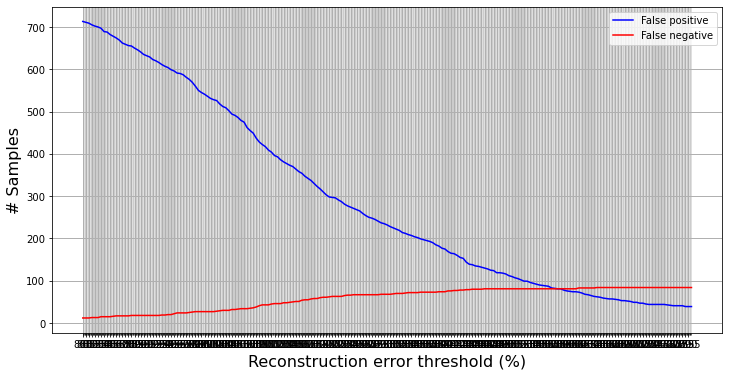

In [53]:
thresholds = np.arange(threshold_min, threshold_max + threshold_step, threshold_step)

df = pd.DataFrame(columns=['Signal', 'Ground Truth', 'Prediction', 'Reconstruction Error'])
df['Signal'] = test_files
df['Ground Truth'] = test_labels
df['Reconstruction Error'] = reconstruction_errors

FN = []
FP = []
for th in thresholds:
    df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
    df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
    df = generate_error_types(df)
    FN.append(df['FN'].sum())
    FP.append(df['FP'].sum())
        
th = plot_curves(FP, FN, nb_samples=df.shape[0], threshold_min=threshold_min, threshold_max=threshold_max, threshold_step=threshold_step)

In [54]:
df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
df['Prediction'] = df['Prediction'].astype(np.float32)
df = generate_error_types(df)
tp = df['TP'].sum()
tn = df['TN'].sum()
fn = df['FN'].sum()
fp = df['FP'].sum()

from sklearn.metrics import confusion_matrix
df['Ground Truth'] = 1 - df['Ground Truth']
df['Prediction'] = 1 - df['Prediction']
print_confusion_matrix(confusion_matrix(df['Ground Truth'], df['Prediction']), class_names=['abnormal', 'normal']);

ValueError: operands could not be broadcast together with shapes (933,) (2,) 

In [55]:
df.to_csv(os.path.join(PROCESSED_DATA, 'results_autoencoder.csv'), index=False)

In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print(f"""Basic autoencoder metrics:
- Precision: {precision*100:.1f}%
- Recall: {recall*100:.1f}%
- Accuracy: {accuracy*100:.1f}%
- F1 Score: {f1_score*100:.1f}%""")

In [58]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# tflite_model.summary()
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ericj\AppData\Local\Temp\tmpvwuh_k3q\assets


INFO:tensorflow:Assets written to: C:\Users\ericj\AppData\Local\Temp\tmpvwuh_k3q\assets
